In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 

# Get celebA dataset

# dataset

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [6]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [7]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [8]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [9]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize,
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    normalize,
])

In [10]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

In [11]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

In [14]:
class SingleGAN_training():
    def __init__(self, net, criterion, lbd, unrolled_k, device, ref_label):
        self.G, self.D, self.E = net[0], net[1], net[2]
        self.optG, self.optD, self.optE = None, None, None
        self.scheG, self.scheD, self.scheE = None, None, None
        self.criterion = criterion
        self.lbd = lbd
        self.k = unrolled_k
        self.device = device
        self.ref_label = ref_label
        self.source_image = None
        self.target_image = None
        self.label = None
        self.c_rand = None
        self.enc_info = None
        self.target_cenc = None
    
    def opt_sche_initialization(self, lr=[0.0001, 0.0001, 0.0001]):
        lr_G, lr_D, lr_E = lr
        self.optG = optim.Adam(self.G.parameters(), lr=lr_G, betas=(0.5, 0.999))
        self.scheG = optim.lr_scheduler.ExponentialLR(self.optG, gamma=0.95)
        self.optD = []
        self.scheD = []
        for i in classes:
            self.optD.append(optim.Adam(self.D[i].parameters(), lr=lr_D, betas=(0.5, 0.999)))
            self.scheD.append(optim.lr_scheduler.ExponentialLR(self.optD[i], gamma=0.95))
        self.optE = optim.Adam(self.E.parameters(), lr=lr_E, betas=(0.5, 0.999))
        self.scheE = optim.lr_scheduler.ExponentialLR(self.optE, gamma=0.95)
        return
        
    def G_transformation(self, target_label, source_image, encoder=False, ref_image=None):
        if encoder:
            class_vector = class_encode(target_label, self.device, self.ref_label)
            latent, mu, logvar = self.E(source_image, class_vector)
            info = [latent, mu, logvar]
            latent_vector = latent
        else:
            latent_vector = torch.randn(source_image.shape[0], ndim).to(device)
            info = latent_vector
            
        class_vector = class_encode(target_label, self.device, self.ref_label)
        class_vector = torch.cat([class_vector, latent_vector], 1)
        target_image = self.G(source_image, class_vector)
        
        return target_image, info
        
    def update_D(self):
        self.target_image, self.c_rand = self.G_transformation(self.label["target"], self.source_image, False)
        self.target_image = normalize_dataset(self.target_image, 1, device, True)
        
        all_errD = 0
        for i in classes:
            self.D[i].zero_grad()
            errD = 0
            real_image = self.source_image[self.label["source"]==i]
            if real_image.shape[0]!=0:
                output = self.D[i](real_image)
                errD_real = get_loss_D(output, 1., criterion, device)
            else:
                errD_real = 0
            errD += errD_real
            
            fake_image = self.target_image[self.label["target"]==i].detach()
            if fake_image.shape[0]!=0:
                output = self.D[i](fake_image)
                errD_fake = get_loss_D(output, 0., criterion, device)
            else:
                errD_fake = 0
            errD += errD_fake
            errD.backward()
            self.optD[i].step()
            all_errD += errD/len(classes)
            
        return all_errD
    
    def update_GandE(self):
        self.G.zero_grad()
        self.E.zero_grad()

        errG = 0
        errE = 0
        errE_output = 0

        ## ordinary SingleGAN loss
        recon_image, source_enc_info = self.G_transformation(self.label["source"], self.target_image, True, self.source_image)
        recon_image = normalize_dataset(recon_image, 1, device, True)
        for i in classes:
            fake_image = self.target_image[self.label["target"]==i]
            if fake_image.shape[0]!=0:
                output = self.D[i](fake_image)
                errG_dis = get_loss_D(output, 1., criterion, device)
            else:
                errG_dis = 0
            errG += errG_dis/len(classes)
        errG_cycle = torch.mean(torch.abs(self.source_image - recon_image))
        errG += errG_cycle*self.lbd["cycle"]
        errE_output += errG_cycle * self.lbd["cycle"]
        
        ## multimodal transformation (KL)
        _, mu, logvar = source_enc_info
        errE_KL = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp_()) 
        errE += errE_KL*self.lbd["KL"]
        errE_output += errE_KL*self.lbd["KL"]
        
        ## Identity loss under source style condition
        if self.lbd["idt"] > 0:
            identity_image, _ = self.G_transformation(self.label["source"], self.source_image, True, self.source_image)
            identity_image = normalize_dataset(identity_image, 1, device, True)
            errG_idt = torch.mean(torch.abs(self.source_image - identity_image))
            errG += errG_idt*self.lbd["idt"]
            errE_output += errG_idt*self.lbd["idt"]
            
        errG.backward(retain_graph=True)
        errE.backward(retain_graph=True)
        self.optG.step()
        self.optE.step()
        
        ## update exclusively G
        self.G.zero_grad()
        
        ## multimodal transformation (regression loss)
        class_vector = class_encode(self.label["target"], self.device, self.ref_label)
        _, target_cenc, _ = self.E(self.target_image, class_vector)
        errG_reg = torch.mean(torch.abs(self.c_rand - target_cenc)) * self.lbd["reg"]
        
        errG_reg.backward()
        self.optG.step()
        
        errG += errG_reg
        
        return [errG, errE_output]
    
    def UnrolledUpdate(self):
        for i in range(self.k):

            # update D
            errD = self.update_D()
            if i==0:
                paramD = []
                for j in classes:
                    paramD.append(self.D[j].state_dict())
                errorD = errD

        # update G and E
        errorG, errorE = self.update_GandE()

        for j in classes:
            self.D[j].load_state_dict(paramD[j])
        return [errorG, errorD, errorE]
        
    def train(self, source_image, label):
        self.source_image = source_image
        self.label = label
        error = self.UnrolledUpdate()
        return error

# conditional GAN

In [15]:
epoch_num = 31
lr_D = 0.0001
lr_G = 0.0002
lr_E = 0.0001
# torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
ndim = 8
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4
save_parameter = False

ref_label = np.eye(len(classes))

In [19]:
devices = [0,1,2,3]
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netG.apply(weights_init)
netG = nn.DataParallel(netG, devices)
netD = []
for i in classes:
    netD.append(SingleDiscriminator_original_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance").to(device))
    netD[i].apply(weights_init)
    netD[i] = nn.DataParallel(netD[i], devices)
netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
netE.apply(weights_init)
netE = nn.DataParallel(netE)
criterion = nn.MSELoss()

## train

In [21]:
lbd = {}
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["KL"] = 0.1
lbd["reg"] = 0.5
unrolled_k = 5

In [22]:
each_train_num = 100
batch_size = 128
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=10)
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=16)
len(dataset), len(testset)

(400, 40)

In [23]:
sg = SingleGAN_training([netG, netD, netE], criterion, lbd, unrolled_k, device, ref_label)
sg.opt_sche_initialization()

1: 0.21389630635579426 mins


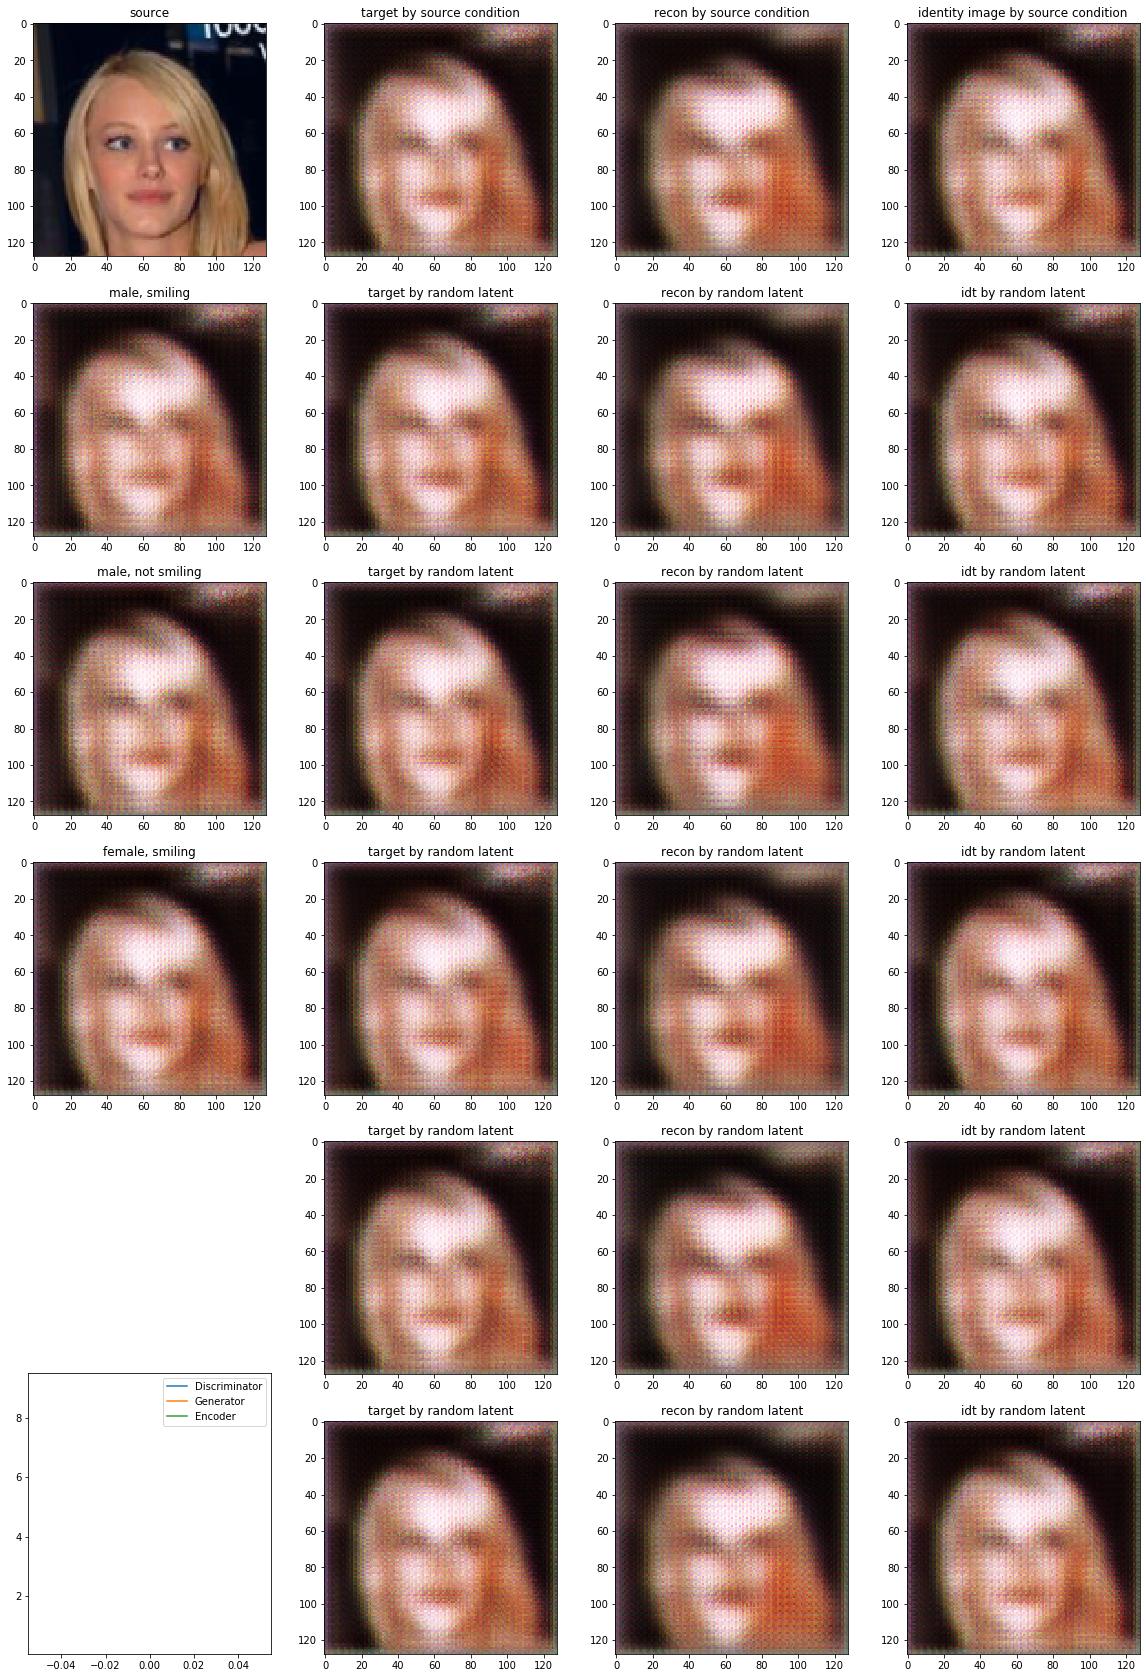

KeyboardInterrupt: 

In [26]:
interval = int(len(dataset)/batch_size/3) + 2
losses_D = []
losses_G = []
losses_E = []
for epoch in range(epoch_num):
    start_time = time.time()
    loss_D = []
    loss_G = []
    loss_E = []
    for itr, data in enumerate(dataloader):
        netG.train()
        data_image = data[0]
        data_label = data[1]
        
        source_image = data_image.to(device)
        label = {}
        label["source"] = data_label.to(device)
        whole_target = get_target(data_label, classes, whole=False)
        label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")
        errG, errD, errE = sg.train(source_image, label)

        if type(errD)!=int:
            errD = cuda2numpy(errD)
            loss_D.append(errD)
        if type(errG)!=int:
            errG = cuda2numpy(errG)
            loss_G.append(errG)
        if type(errE)!=int:
            errE = cuda2numpy(errE)
            loss_E.append(errE)
            
        if itr%interval==0:
            if not itr==0:
                clear_output(wait=True)
                print(f"epoch {epoch} :itr {itr}/{int(len(dataset)/batch_size)}: {(time.time()-start_time)/60} mins")
                fig = get_output_and_plot(sg, sampleset, 53, 5, False)
                
                if not epoch==0:
                    length = 5
                    width = 4
                    losses = [losses_D, losses_G, losses_E]
                    ax = fig.add_subplot(length, width, 17)
                    models = ["Discriminator", "Generator", "Encoder"]
                    for k in range(len(losses)):
                        if models[k] == "Discriminator":
                            if type(losses[k]) == dict:
                                for i in classes:
                                    ax.plot(losses[k][i], label=f"Discriminator-{i}")
                            elif type(losses[k]) == list:
                                ax.plot(losses[k], label=f"Discriminator")
                        else:
                            ax.plot(losses[k], label=models[k])
                    ax.legend()
                plt.show()
        
    if save_parameter:
        if epoch % 3 == 0:
            
            torch.save(sg.G.module.state_dict(), f"./instant_model_parameter/gen_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")
            torch.save(sg.E.module.state_dict(), f"./instant_model_parameter/enc_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")
            for i in classes:
                torch.save(sg.D[i].module.state_dict(), f"./instant_model_parameter/dis-{i}_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")
            
            
    for i in classes:
        sg.scheD[i].step()
    losses_D.append(np.mean(loss_D))
    sg.scheG.step()
    losses_G.append(np.mean(loss_G))
    sg.scheE.step()
    losses_E.append(np.mean(loss_E))
    
    clear_output(wait=True)
    print(f"{epoch+1}: {(time.time()-start_time)/60} mins")
    fig = get_output_and_plot(sg, sampleset, 53, 5, False)
    
    length = 5
    width = 4
    losses = [losses_D, losses_G, losses_E]
    ax = fig.add_subplot(length, width, 17)
    models = ["Discriminator", "Generator", "Encoder"]
    for k in range(len(losses)):
        if models[k] == "Discriminator":
            if type(losses[k]) == dict:
                for i in classes:
                    ax.plot(losses[k][i], label=f"Discriminator-{i}")
            elif type(losses[k]) == list:
                ax.plot(losses[k], label=f"Discriminator")
        else:
            ax.plot(losses[k], label=models[k])
    ax.legend()
    
    plt.show()

In [ ]:
# fig = get_output_and_plot(sg.G, sg.E, sampleset, 53)

## Results

In [127]:
label_type = "target_only"
transformation_type = "normal"
cat = 2 if label_type=="concatenation" else 1
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, norm_type, num_con=continuous_label.shape[1]*cat+ndim).to(device)
netG = nn.DataParallel(netG)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, norm_type, continuous_label.shape[1]).to(device)
netD = nn.DataParallel(netD)
netE = Encoder(nch_in, ndim, nch, 4, norm_type, continuous_label.shape[1]).to(device)
netE = nn.DataParallel(netE)
sg = SingleGAN_training([netG, netD, netE], [criterion, criterion_class], 
                       lbd, unrolled_k, label_type, device, continuous_label, transformation_type)
sg.opt_sche_initialization()

In [144]:
lbd = {}
lbd["class"] = 10
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["multiple"] = 0
lbd["gp"] = 1
lbd["KL"] = 0.1
lbd["reg"] = 1 
lbd["class_enc"] = 1
unrolled_k = 5
load_epoch = 15
load_parameter = True

if load_parameter:
    # multiple transformation and classification in encoder
    gen_path = f"./instant_model_parameter/gen_multimodal_{transformation_type}E_{len(classes)}to{continuous_label.shape[1]}classes_continuousGAN_{label_type}_celebA_lbd_idt{lbd['idt']}_lbd_cycle{lbd['cycle']}_lbd_gp{lbd['gp']}_lbd_KL{lbd['KL']}_lbd_reg{lbd['reg']}_lbd_classenc{lbd['class_enc']}_lbd_multiple{lbd['multiple']}_gen_nch{nch}_reduce{reduce}_ncls{num_cls}_nres{res_num}_norm_{norm_type}_dis_nch{dis_nch}_reduce{dis_reduce}_ncls{num_cls}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
    dis_path = f"./instant_model_parameter/dis_multimodal_{transformation_type}E_{len(classes)}to{continuous_label.shape[1]}classes_continuousGAN_{label_type}_celebA_lbd_idt{lbd['idt']}_lbd_cycle{lbd['cycle']}_lbd_gp{lbd['gp']}_lbd_KL{lbd['KL']}_lbd_reg{lbd['reg']}_lbd_classenc{lbd['class_enc']}_lbd_multiple{lbd['multiple']}_gen_nch{nch}_reduce{reduce}_ncls{num_cls}_nres{res_num}_norm_{norm_type}_dis_nch{dis_nch}_reduce{dis_reduce}_ncls{num_cls}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
    enc_path = f"./instant_model_parameter/enc_multimodal_{transformation_type}E_{len(classes)}to{continuous_label.shape[1]}classes_continuousGAN_{label_type}_celebA_lbd_idt{lbd['idt']}_lbd_cycle{lbd['cycle']}_lbd_gp{lbd['gp']}_lbd_KL{lbd['KL']}_lbd_reg{lbd['reg']}_lbd_classenc{lbd['class_enc']}_lbd_multiple{lbd['multiple']}_gen_nch{nch}_reduce{reduce}_ncls{num_cls}_nres{res_num}_norm_{norm_type}_dis_nch{dis_nch}_reduce{dis_reduce}_ncls{num_cls}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
    
    gen_model = torch.load(gen_path)
    dis_model = torch.load(dis_path)
    enc_model = torch.load(enc_path)
    
    netG.load_state_dict(gen_model)
    netD.load_state_dict(dis_model)
    netE.load_state_dict(enc_model)

In [150]:
gen_path

'./instant_model_parameter/gen_multimodal_normalE_4to3classes_continuousGAN_target_only_celebA_lbd_idt5_lbd_cycle5_lbd_gp1_lbd_KL0.1_lbd_reg1_lbd_classenc1_lbd_multiple0_gen_nch64_reduce2_ncls2_nres6_norm_instance_dis_nch64_reduce2_ncls2_unrolledk5_epoch15.pth'

In [145]:
load_parameter = False
if load_parameter:
    gen_path = f"./model_parameters/Mpaper/61/gen_multimodal_4to3classes_continuousGAN_target_only_celebA_lbd_idt0_lbd_cycle10_lbd_gp1_lbd_KL0.1_lbd_reg1_gen_nch64_reduce2_ncls2_nres6_norm_instance_dis_nch64_reduce2_ncls2_unrolledk5_epoch25.pth" # normalE
#     gen_path = f"./model_parameters/Mpaper/61/gen_multimodal_edgeE_4to3classes_continuousGAN_target_only_celebA_lbd_idt0_lbd_cycle10_lbd_gp1_lbd_KL0.1_lbd_reg1_gen_nch64_reduce2_ncls2_nres6_norm_instance_dis_nch64_reduce2_ncls2_unrolledk5_epoch35.pth" # edge detectorE
#     gen_path = f"./model_parameters/Mpaper/61/gen_multimodal_edge_emphasisE_4to3classes_continuousGAN_target_only_celebA_lbd_idt0_lbd_cycle10_lbd_gp1_lbd_KL0.1_lbd_reg1_gen_nch64_reduce2_ncls2_nres6_norm_instance_dis_nch64_reduce2_ncls2_unrolledk5_epoch25.pth" # edge emphasis
    gen_model = torch.load(gen_path)
    sg.G.load_state_dict(gen_model)

In [146]:
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=16)

### generation in various latent code

In [147]:
num = 64
latent_code = np.random.randn(num, ndim) * np.sqrt(10)

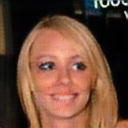

In [148]:
data, label = get_samples_latent(netG, testset, 53, 2, latent_code, classes, continuous_label, label_type, transformation_type, ndim)
data["target"][0]

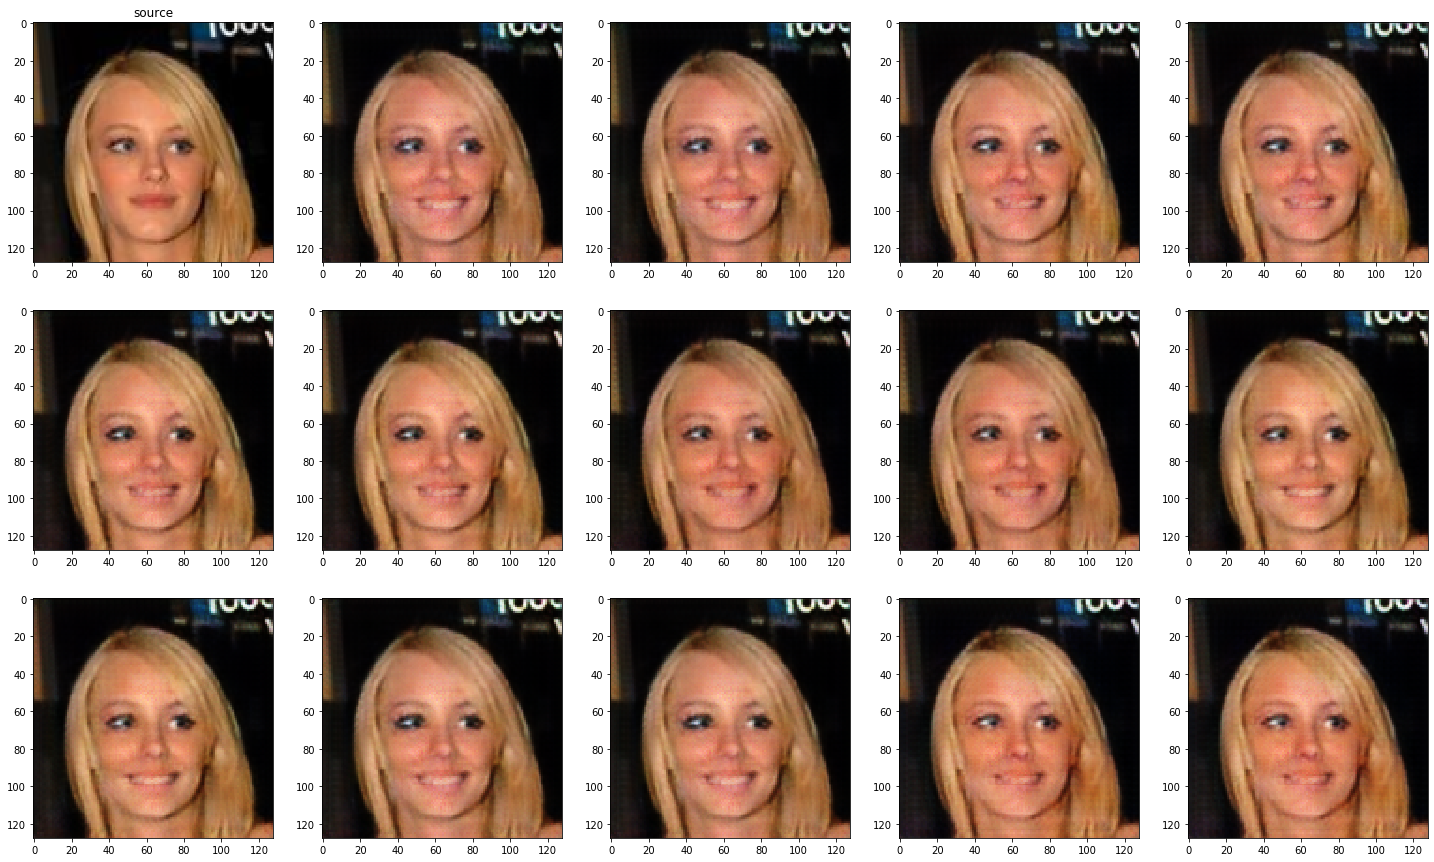

In [149]:
length = 3
width = 5
fig = plt.figure(figsize=(5*width, 5*length))

index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length*width-1):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(data["target"][i])

In [50]:
normal_save = False
edge_save = False
edge_emphasis_save = False
if normal_save:
    # normal image gif
#     save_path = f"pic/61/normal-image_{transformation_type}.gif"
    save_path = f"test.gif"
    save_gif(data["target"], save_path, duration=150)

if edge_save:
    # edge image gif
    save_path = f"pic/61/edge-image_{transformation_type}.gif"
    save_gif(data["edge"]["target"], save_path, duration=200)

if edge_emphasis_save:
    # edge-emphasized image gif
    save_path = f"pic/61/emphasized-image_{transformation_type}.gif"
    save_gif(data["edge_emphasis"]["target"], save_path, duration=200)

### generation in various image sample

In [132]:
def get_samples_multimodal(netG, netE, dataset, index_list, latent=None, classes=tuple(range(4)), ref_label=None, 
                                 label_type="target_only", transformation_type="normal", ndim=8, device="cuda"):
    """
    get some samples of the outputs in multimodal-SingleGAN.
    
    Parameters
    ------------
    netG : PyTorch model
        the generator of the SingleGAN
        
    netE : PyTorch model
        the encoder of the SingleGAN
        
    dataset : Dataset in PyTorch
        dataset which is used in the inference task
        
    index_list : list
        the list of the index which indicates data location in the dataset
        
    latent : None or ndarray, shape=(sample_num, latent_dim)
        latent indicates the "style" of generated data
        
    classes : tuple
        the class list(tuple)
        
    ref_label : ndarray
        continuous class label (relational label or moving label)
        
    label_type : 'target_only', 'concatenation', or 'substruction'
        the target label for transformation
        'target_only' -> only target label
        'concatenation' -> concatenation of the target label and the source label
        'substruction' -> substruction of the target label and the source label
        
    transformation_type : 'normal', 'edge', or 'edge_emphasis'
        the represenation which is used for the input of the E
        
    ndim : int 
        the dimension of the latent code
        
    device : 'cpu' or 'cuda'
        the device which is used
    
    Returns
    ----------
    data : dic
        dictionary of whole data
        
    label : dic
        dictionary of whole label
        
    """
    
    
    data, label = dic_init(False)
        
    for index in index_list:
        fixed_source_image = dataset[index][0].view(1, 3, 128, 128).to(DEVICE)
        fixed_source_label = torch.tensor([dataset[index][1]])
        sample_source = image_from_output(fixed_source_image)[0]
        fixed_target_label = torch.tensor(get_target(fixed_source_label, classes, whole=False, shuffle=False))

        x, y = dic_init(False)
        y["source"] = gpu_to_np(fixed_source_label)
        y["target"] = gpu_to_np(fixed_target_label)
        x["source"] = image_from_output(fixed_source_image)[0]

        netG.eval()
        netE.eval()
        for i in range(len(classes)-1):
            target_label = fixed_target_label[:,i:i+1]

            # get target image
            if type(latent)==np.ndarray:
                latent = torch.tensor(latent, dtype=torch.float32).to(DEVICE)
            else:
                latent = torch.randn(fixed_source_image.shape[0], ndim).to(DEVICE)
            class_vector = class_encode(target_label, DEVICE, ref_label, label_type, fixed_source_label)
            class_vector = torch.cat([class_vector, latent], 1)
            fixed_target_image = netG(fixed_source_image, class_vector)

            # get reconstructed image
            class_vector = class_encode(fixed_source_label, DEVICE, ref_label, label_type, target_label)
            source_vector = class_encode(fixed_source_label, DEVICE, ref_label, "target_only")
            ref_image = edge_transformation(fixed_source_image, transformation_type, None, device)
            latent, mu, logvar, _ = netE(ref_image)
            class_vector = torch.cat([class_vector, latent], 1)
            fixed_recon_image = netG(fixed_target_image, class_vector)

            x["target"].append(image_from_output(fixed_target_image)[0])
            x["recon"].append(image_from_output(fixed_recon_image)[0])
        
        for datatype in ["source", "target", "recon"]:
            data[datatype].append(x[datatype])
            if datatype in ["recon"]:
                continue
            label[datatype].append(y[datatype])
            
    return data, label

In [133]:
transformation_type
label_type

'target_only'

In [137]:
dis_class = 1
data, label = get_samples_multimodal(sg.G, sg.E, testset, range((dis_class-1)*testnum, dis_class*testnum), None, classes, continuous_label, label_type, transformation_type, ndim)

In [ ]:
for i in range(len(data["source"])):
    print(range((dis_class-1)*testnum, dis_class*testnum)[i])
    plot_results(data["source"][i:i+1], data["target"][i:i+1], data["recon"][i:i+1], label["source"][i:i+1], label["target"][i:i+1], True, classes=classes)

In [136]:
data, label = get_multi_samples_multimodal(sg.G, sg.E, testset, range(len(testset)), classes, continuous_label, label_type, ndim)
for i in range(len(data["source"])):
    plot_results(data["source"][i:i+1], data["target"][i:i+1], data["recon"][i:i+1], label["source"][i:i+1], label["target"][i:i+1], True, classes=classes)

NameError: name 'get_multi_samples_multimodal' is not defined

### identitity and reconstructed image transformation

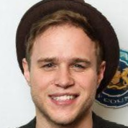

In [103]:
netG.eval()
netE.eval()
testdata = testset[14]
# testdata = testset[53]
fixed_source_image = testdata[0].view(1, 3, 128, 128).to(DEVICE)
fixed_source_label = torch.tensor(testdata[1]).view(1,)
image_from_output(fixed_source_image)[0]

In [52]:
# get target label
fixed_target_label = torch.tensor(get_target(fixed_source_label, classes, whole=False, shuffle=False))
target_label = fixed_target_label[:,0:1]
# target_label[0][0] = 3

In [53]:
# get target image by several latent codes
target_num = 5
ref_label = continuous_label
latent = torch.randn(target_num, ndim).to(DEVICE)
class_vector = class_encode(target_label.repeat(1,target_num), DEVICE, ref_label, label_type, fixed_source_label)
class_vector = torch.cat([class_vector, latent], 1)
target_image_list = cuda_to_cpu(netG(fixed_source_image.repeat(target_num,1,1,1), class_vector))

In [56]:
# get reconstructed image under source condition
class_vector = class_encode(fixed_source_label, DEVICE, ref_label, label_type, target_label)
ref_image = edge_transformation(fixed_source_image, transformation_type, None, device)
latent, _, _, _ = netE(ref_image)
class_vector = torch.cat([class_vector, latent], 1)
fixed_recon_image = cuda_to_cpu(netG(target_image_list[0:1].to(device), class_vector))

In [57]:
# get identity image under source condition
ref_image = edge_transformation(fixed_source_image, transformation_type, None, device)
latent, _, _, _ = netE(ref_image)
class_vector = class_encode(fixed_source_label, DEVICE, ref_label, label_type, None)
class_vector = torch.cat([class_vector, latent], 1)
fixed_identity_image = cuda_to_cpu(netG(fixed_source_image, class_vector))

In [58]:
# get transformed image under class condition
fixed_latent = torch.randn(fixed_source_image.shape[0], ndim).repeat(len(classes)-1,1).to(DEVICE)
class_vector = class_encode(fixed_target_label, DEVICE, ref_label, label_type, None)
latent = torch.randn(fixed_source_image.shape[0], ndim).to(DEVICE)
class_vector = torch.cat([class_vector, fixed_latent], 1)
trans_image_list = cuda_to_cpu(netG(fixed_source_image.repeat(len(classes)-1,1,1,1), class_vector))

In [59]:
# get reconstructed image by several latent code
recon_num = 4
class_vector = class_encode(fixed_source_label.repeat(recon_num), DEVICE, ref_label, label_type, None)
latent = torch.randn(recon_num, ndim).to(DEVICE)
class_vector = torch.cat([class_vector, latent], 1)
recon_image_list = cuda_to_cpu(netG(target_image_list[0:1].repeat(recon_num,1,1,1).to(device), class_vector))

In [60]:
# get idt image by several latent code
idt_num = 4
latent = torch.randn(idt_num, ndim).to(DEVICE)
class_vector = class_encode(fixed_source_label.repeat(idt_num), DEVICE, ref_label, label_type, None)
class_vector = torch.cat([class_vector, latent], 1)
idt_image_list = cuda_to_cpu(netG(fixed_source_image.repeat(idt_num,1,1,1), class_vector))

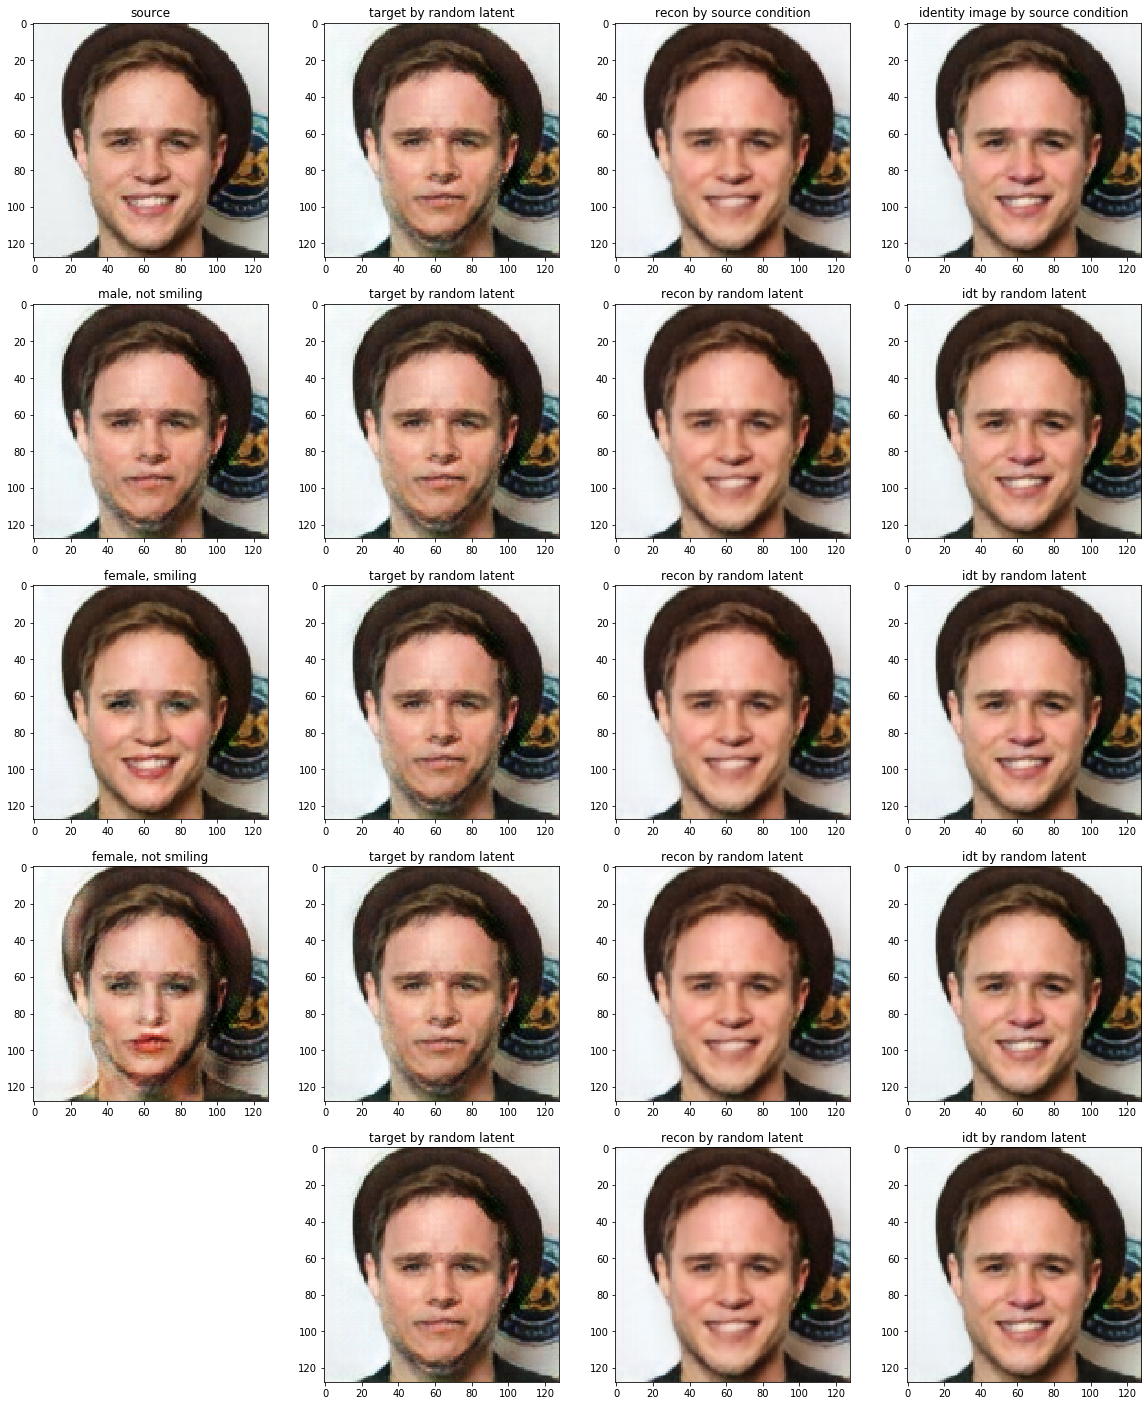

In [61]:
length = 5
width = 4
fig = plt.figure(figsize=(5*width, 5*length))

index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(image_from_output(fixed_source_image)[0])
ax.set_title("source")
index = 3
ax = fig.add_subplot(length, width, index)
ax.imshow(image_from_output(fixed_recon_image)[0])
ax.set_title("recon by source condition")
index = 4
ax = fig.add_subplot(length, width, index)
ax.imshow(image_from_output(fixed_identity_image)[0])
ax.set_title("identity image by source condition")

for i in range(len(classes)-1):
    index = 4*(i+1)+1
    ax = fig.add_subplot(length, width, index)
    ax.imshow(image_from_output(trans_image_list[i:i+1])[0])
    ax.set_title(label_discription[fixed_target_label[0][i]])
    
for i in range(target_num):
    index = 4*i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(image_from_output(target_image_list[i:i+1])[0])
    ax.set_title("target by random latent")

for i in range(recon_num):
    index = 4*(i+1)+3
    ax = fig.add_subplot(length, width, index)
    ax.imshow(image_from_output(recon_image_list[i:i+1])[0])
    ax.set_title("recon by random latent")
    
for i in range(idt_num):
    index = 4*(i+1)+4
    ax = fig.add_subplot(length, width, index)
    ax.imshow(image_from_output(idt_image_list[i:i+1])[0])
    ax.set_title("idt by random latent")

### multiple transformation

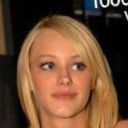

In [104]:
netG.eval()
netE.eval()
testdata = testset[53]
fixed_source_image = testdata[0].view(1, 3, 128, 128).to(DEVICE)
fixed_source_label = torch.tensor(testdata[1]).view(1,)
image_from_output(fixed_source_image)[0]

In [105]:
# get target label
fixed_target_label = torch.tensor(get_target(fixed_source_label, classes, whole=False, shuffle=False))
ref_label = continuous_label

In [127]:
transformation_num = 3
images = {}
images["target"] = {}
images["recon"] = {}
for i in range(transformation_num):
    target_label = fixed_target_label[:,i:i+1]
    latent = torch.randn(1, ndim).to(DEVICE)
    class_vector = class_encode(target_label, DEVICE, ref_label, label_type, fixed_source_label)
    class_vector = torch.cat([class_vector, latent], 1)
    target_image = netG(fixed_source_image, class_vector)
    images["target"][str(i)] = image_from_output(target_image)[0]
    
    class_vector = class_encode(fixed_source_label, DEVICE, ref_label, label_type, target_label)
    ref_image = edge_transformation(fixed_source_image, transformation_type, None, device)
    latent, _, _, _ = netE(ref_image)
    class_vector = torch.cat([class_vector, latent], 1)
    recon_image = netG(target_image, class_vector)
    images["recon"][str(i)] = image_from_output(recon_image)[0]

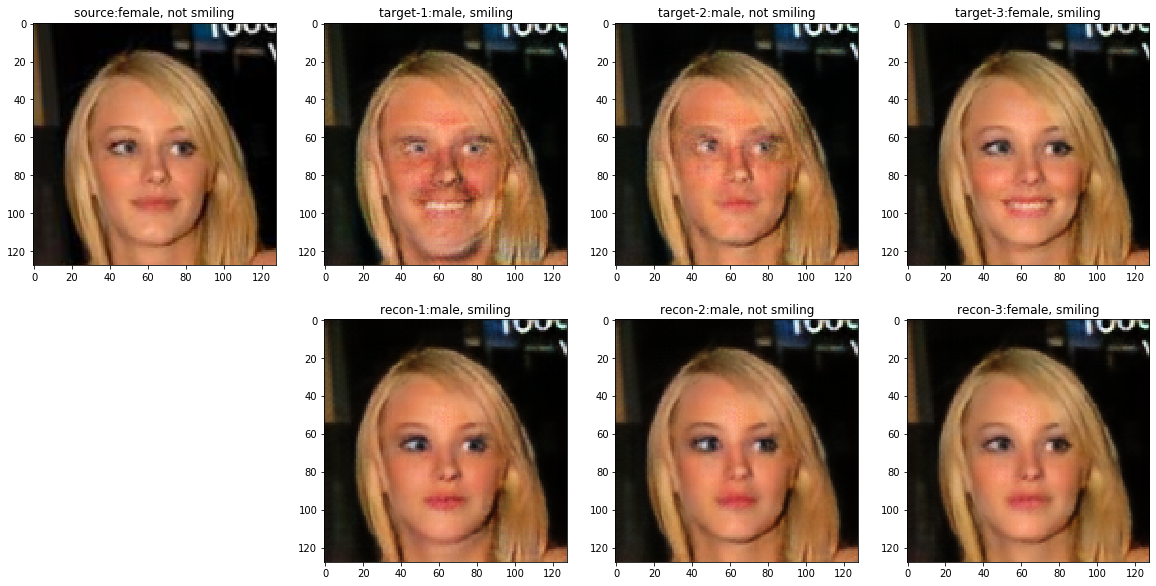

In [131]:
length = 2
width = transformation_num + 1
fig = plt.figure(figsize=(5*width, 5*length))

index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(image_from_output(fixed_source_image)[0])
ax.set_title(f"source:{label_discription[fixed_source_label[0]]}")
for i in range(transformation_num):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images["target"][str(i)])
    ax.set_title(f"target-{i+1}:{label_discription[fixed_target_label[0][i]]}")
    
    index = i+6
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images["recon"][str(i)])
    ax.set_title(f"recon-{i+1}:{label_discription[fixed_target_label[0][i]]}")

### Encoder

In [90]:
# netE = Encoder_classifier(nch_in, ndim, nch, 4, norm_type, continuous_label.shape[1]).to(device)

In [91]:
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=100)
sampleloader = torch.utils.data.DataLoader(dataset=sampleset, batch_size=32, shuffle=True)
len(sampleset)

400

In [92]:
sg.E = netE
sg.G = netG
sg.D = netD

In [102]:
for itr, data in enumerate(sampleloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    ref_image = edge_transformation(data_image, transformation_type, None, device)
    class_vector = class_encode(data_label, DEVICE, continuous_label, "target_only")
    latent, mu, logvar = netE(ref_image, class_vector)
    
    fixed_target_label = torch.tensor(get_target(data_label, classes, whole=False, shuffle=False))
    target_label = fixed_target_label[:,0:1]
    target_image, source_enc = sg.G_transformation(target_label, data_image, True, data_image)
    _, rand_enc, _, = source_enc
    ref_image = edge_transformation(target_image, transformation_type, None, device)
    class_vector = class_encode(target_label, DEVICE, continuous_label, "target_only")
    _, mu_target, _, = netE(ref_image, class_vector)
    
    if itr==0:
        latent_list = cuda_to_cpu(latent)
        mu_list = cuda_to_cpu(mu)
        logvar_list = cuda_to_cpu(logvar)
        true_label = cuda_to_cpu(data_label)
        mu_target_list = cuda_to_cpu(mu_target)
        rand_enc_list = cuda_to_cpu(rand_enc)
    else:
        latent_list = np.concatenate([latent_list, cuda_to_cpu(latent)], axis=0)
        mu_list = np.concatenate([mu_list, cuda_to_cpu(mu)], axis=0)
        logvar_list = np.concatenate([logvar_list, cuda_to_cpu(logvar)], axis=0)
        true_label = np.append(true_label, cuda_to_cpu(data_label))
        mu_target_list = np.concatenate([mu_target_list, cuda_to_cpu(mu_target)], axis=0)
        rand_enc_list = np.concatenate([rand_enc_list, cuda_to_cpu(rand_enc)], axis=0)

#### distribution

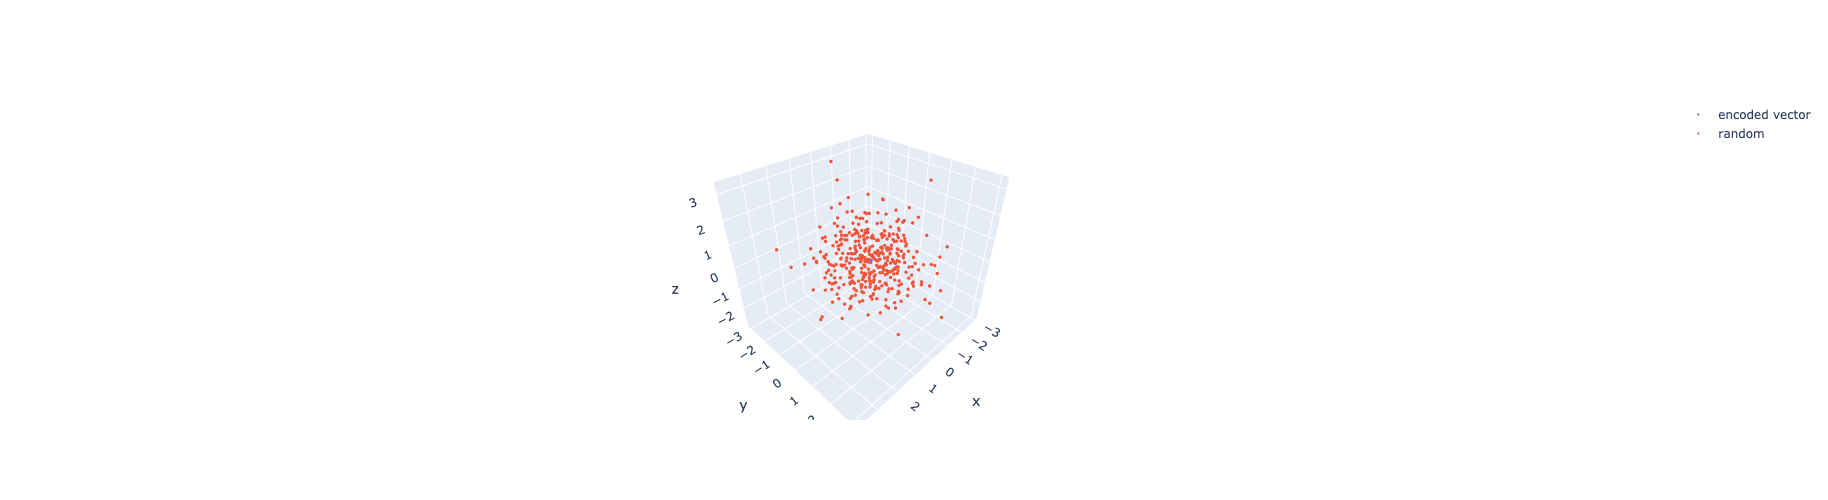

In [103]:
trace = []
    
# for lbl in range(len(classes)):
#     m = latent_list[true_label==lbl]
m = mu_target_list
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"encoded vector", 
                          marker = dict(size=2)))

m = np.random.randn(400, 3)
# m = mu_list
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"random", 
                          marker = dict(size=2)))


layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

#### qualitative evaluation

In [135]:
for itr, data in enumerate(sampleloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    idt_image, source_enc_info = sg.G_transformation(data_label, data_image, True, data_image)
    ref_image = edge_transformation(idt_image, transformation_type, None, device)
#     _, source_cenc, _, _ = source_enc_info
#     _, idt_cenc, _, _ = netE(ref_image)
    source_cenc, _, _, _ = source_enc_info
    idt_cenc, _, _, _ = netE(ref_image)
    print(np.sum(np.abs(cuda_to_numpy(idt_cenc) - cuda_to_numpy(source_cenc))))
    
    idt_random_image, source_c_rand = sg.G_transformation(data_label, data_image, False)
    ref_image = edge_transformation(idt_random_image, transformation_type, None, device)
#     _, idt_cenc_rand, _, _ = netE(ref_image)
    idt_cenc_rand, _, _, _ = netE(ref_image)
    print(np.sum(np.abs(cuda_to_numpy(source_c_rand) - cuda_to_numpy(idt_cenc_rand))))
    
    if itr==0:
        latent_list = cuda_to_cpu(latent)
        mu_list = cuda_to_cpu(mu)
        logvar_list = cuda_to_cpu(logvar)
        class_output_list = cuda_to_cpu(class_output)
        true_label = cuda_to_cpu(data_label)
    else:
        latent_list = np.concatenate([latent_list, cuda_to_cpu(latent)], axis=0)
        mu_list = np.concatenate([mu_list, cuda_to_cpu(mu)], axis=0)
        logvar_list = np.concatenate([logvar_list, cuda_to_cpu(logvar)], axis=0)
        class_output_list = np.concatenate([class_output_list, cuda_to_cpu(class_output)], axis=0)
        true_label = np.append(true_label, cuda_to_cpu(data_label))

203.69296
301.2121
198.75586
298.95273
183.143
283.08557
196.0726
284.68567
203.59778
284.22443
203.99939
289.78708
189.54163
254.91072
205.99455
293.63336
212.75055
284.27768
199.59532
293.97452
212.527
297.08527
191.97772
287.12842
99.12133
136.38997


In [141]:
data_num = 5
for itr, data in enumerate(sampleloader):
    
    netE.eval()
    data_image = data[0].to(device)[:data_num]
    data_label = data[1].to(device)
    
    for i in range(50):
        ref_image = edge_transformation(data_image, transformation_type, None, device)
        latent, mu, _, _ = netE(ref_image)

        if i==0:
            latent_list = cuda_to_cpu(latent)
            mu_list = cuda_to_cpu(mu)
        else:
            latent_list = np.concatenate([latent_list, cuda_to_cpu(latent)], axis=0)
            mu_list = np.concatenate([mu_list, cuda_to_cpu(mu)], axis=0)
    break
    
all_latent = np.zeros((data_num, 50, 8))
for i in range(data_num):
    all_latent[i] = latent_list.reshape(50, -1)[:,8*i:8*(i+1)]
    
# for itr, data in enumerate(sampleloader):
    
#     netE.eval()
#     data_image = data[0].to(device)[1:2]
#     data_label = data[1].to(device)
    
#     for i in range(50):
#         ref_image = edge_transformation(data_image, transformation_type, None, device)
#         latent, mu, _, _ = netE(ref_image)

#         if i==0:
#             latent2_list = cuda_to_cpu(latent)
#             mu_list2 = cuda_to_cpu(mu)
#         else:
#             latent2_list = np.concatenate([latent2_list, cuda_to_cpu(latent)], axis=0)
#             mu2_list = np.concatenate([mu_list2, cuda_to_cpu(mu)], axis=0)
#     break

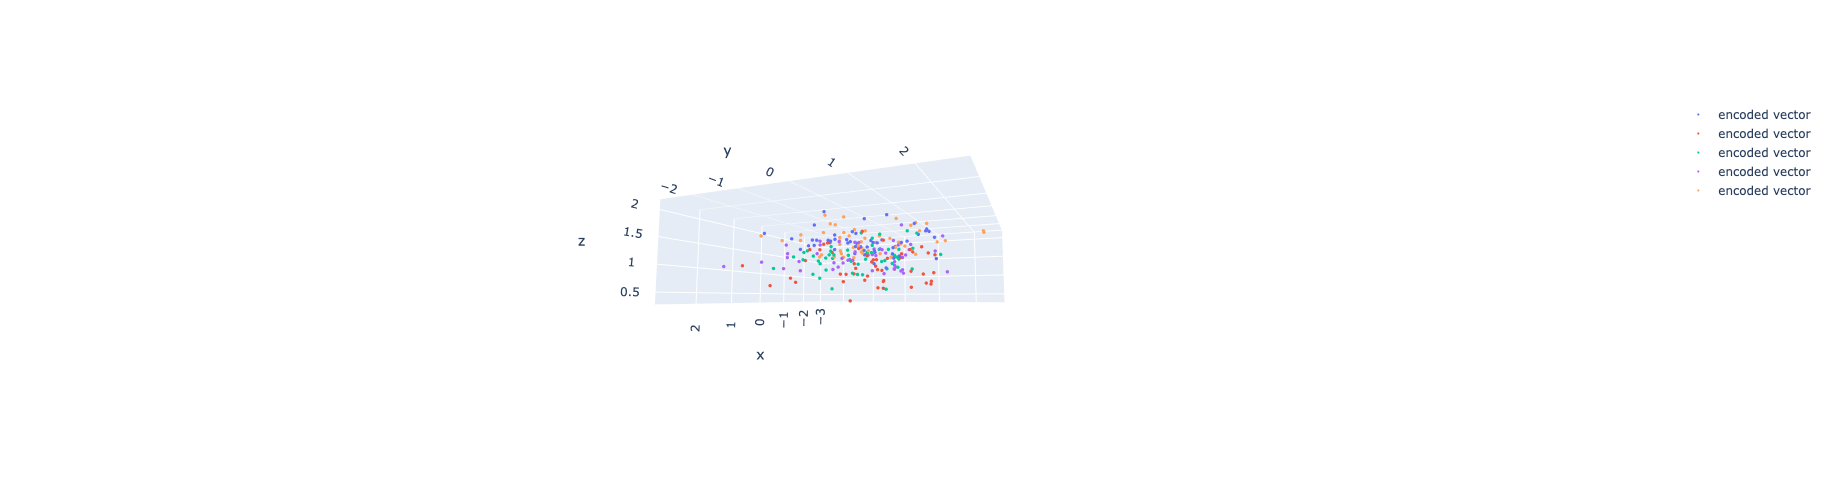

In [142]:
trace = []
    
# for lbl in range(len(classes)):
#     m = latent_list[true_label==lbl]
for i in range(data_num):
    m = all_latent[i]
    _x = m[:, 0] 
    _y = m[:, 1]
    _z = m[:, 2]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"encoded vector", 
                              marker = dict(size=2)))

layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

1.0